In [1]:
%matplotlib inline
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import keras.applications as pretrained
import keras.preprocessing.image as preprocessing
import matplotlib.image as mpimg
import keras.layers as layers
import keras.optimizers as optimizers
import keras.models as models
import keras.callbacks as callbacks

Using TensorFlow backend.


### Load Images
Use image generator to load image from directory and set augmentation parameters.

In [2]:
data_dir = '../../data/dogscats/sample/'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
batch_size=128

train_generator = preprocessing.ImageDataGenerator(
#     zoom_range=0.1,
#     shear_range=0.03,
#     rotation_range=10,
#     height_shift_range=0.07,
#     width_shift_range=0.07,
#     horizontal_flip=True
)

train_data = train_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=1
)


val_generator = preprocessing.ImageDataGenerator()
val_data = val_generator.flow_from_directory(val_dir, batch_size=batch_size, target_size=(224,224), shuffle=False)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


### Examine data

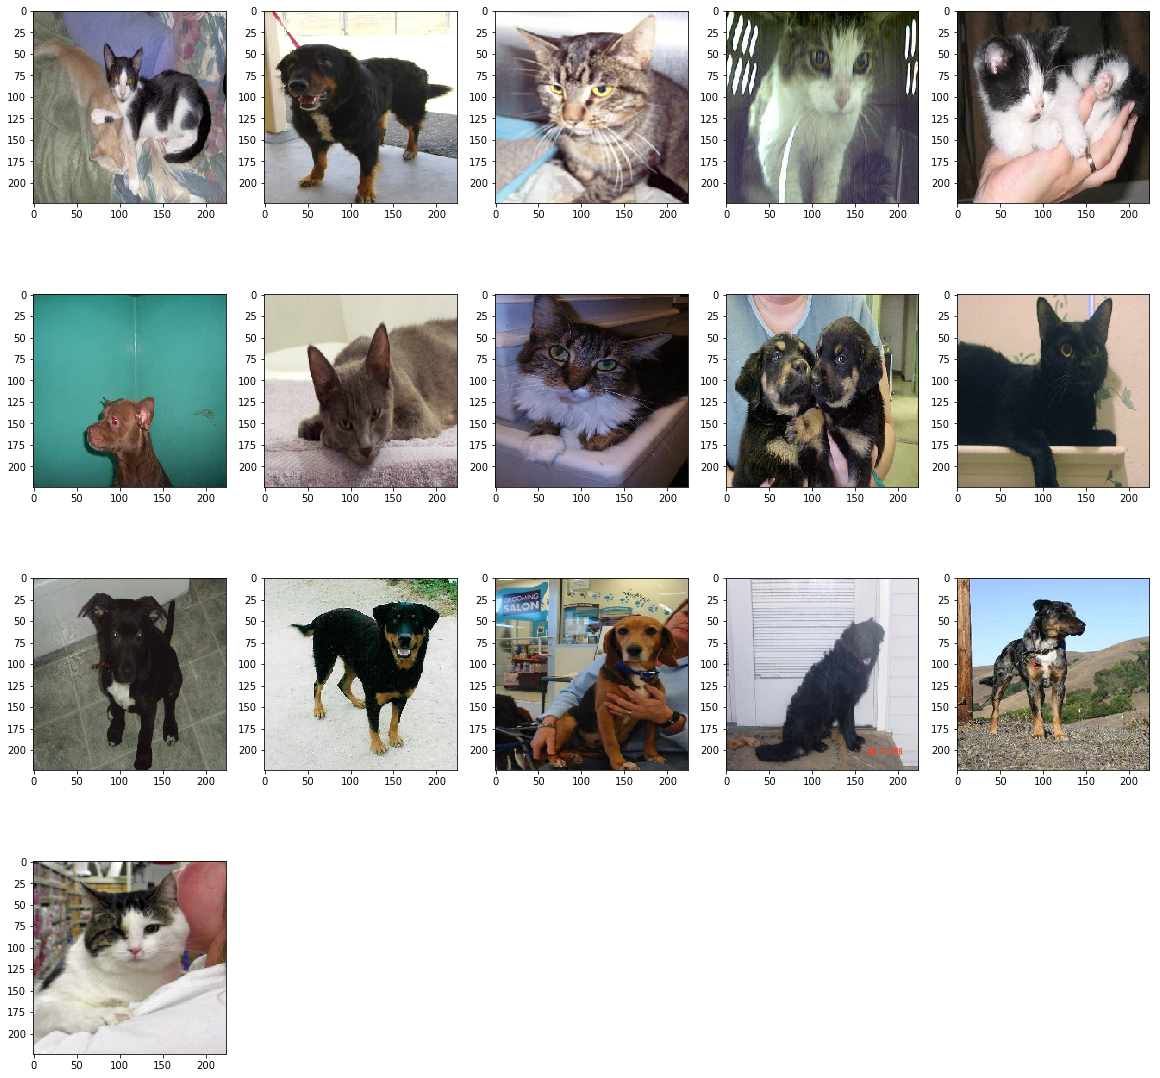

In [3]:
batch = next(train_data)
imgs = batch[0]
n_imgs = imgs.shape[0]
n_cols = 5
n_rows = int(math.ceil(n_imgs / n_cols))
f = plt.figure(figsize=(20,20))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(imgs[i,:,:,:].astype(np.uint8))

### Build Network
- Load VGG-16 from applications
- Replace last two affine layers from original network with untrained layers

In [4]:
vgg = pretrained.VGG16()
vgg_layers = vgg.layers

# Remove final layers
vgg_layers.pop()
vgg_layers.pop()

# Reset output nodes of the final layer that's being kept
vgg_layers[-1].outbound_nodes = []

# "Freeze" other layers, so they aren't updated during training
for trained_layer in vgg_layers:
    trained_layer.trainable = False

# Add two new dense layers.
output = vgg_layers[-1].output
output = layers.Dense(4096, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(2, activation='softmax')(output)
vgg = models.Model(inputs=vgg.input, outputs=output)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Train Network
- Add tensorboard
- Add checkpointing that saves best model (measured by val loss)
- Add lr decay

**Create callbacks**

In [5]:
loss_graph = callbacks.TensorBoard() # default log file is ./logs
model_checkpoint = callbacks.ModelCheckpoint('test', save_best_only=True)
lr_decay = callbacks.ReduceLROnPlateau()

In [7]:
vgg.compile(optimizer=optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
vgg.fit_generator(
    train_data,
    steps_per_epoch=4,
    epochs=1,
    validation_data=val_data,
    validation_steps=1,
    callbacks=[loss_graph, model_checkpoint, lr_decay]
)

Epoch 1/1
4/4 [==============================] - 30s - loss: 1.7695e-07 - acc: 1.0000 - val_loss: 2.0286 - val_acc: 0.8750
